# Autoencoder for getting vector embeddings

**Advisor:** Marcos M. Raimundo <br>
**Co-Advisor:** Thalita Veronese <br>
**Student:** João Victor P. B. Avanzini

## Imports

In [1]:
import tensorflow as tf
import os

import neurokit2 as nk


import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Input, Conv1DTranspose, Conv2DTranspose, Reshape
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
import tensorflow as tf

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping: no known devices.


## Data generation - ECG from NeuroKit2

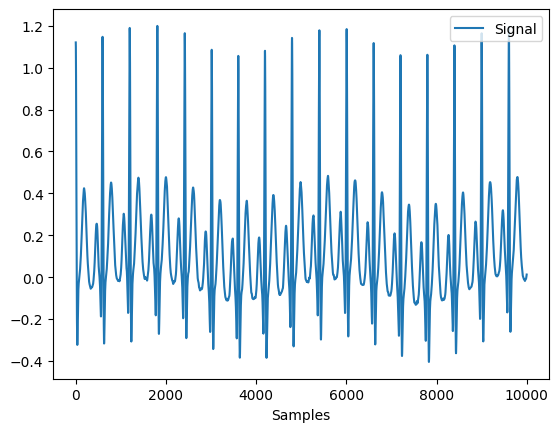

In [2]:
ecg100 = nk.ecg_simulate(duration=10, noise=0.01, heart_rate=100)

ecg_df = pd.DataFrame({"ECG_100": ecg100})

nk.signal_plot(ecg100)

In [3]:
type(ecg100)

numpy.ndarray

In [4]:
ecg100.shape

(10000,)

## Single ECG autoencoder

In [5]:
encoder = tf.keras.models.Sequential([
    Conv1D(64, 10, activation='relu', padding='same', input_shape=(10000, 1)),
    Dense(32, activation='relu'),
    MaxPooling1D(),
    Conv1D(32, 10, activation='relu', padding='same'),
    Dense(16, activation='relu'),
    MaxPooling1D(),
    Flatten(),
    Dense(8)
    
], name='encoder')

In [6]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10000, 64)         704       
                                                                 
 dense (Dense)               (None, 10000, 32)         2080      
                                                                 
 max_pooling1d (MaxPooling1  (None, 5000, 32)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 5000, 32)          10272     
                                                                 
 dense_1 (Dense)             (None, 5000, 16)          528       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 2500, 16)          0         
 g1D)                                                      

In [7]:
decoder = tf.keras.models.Sequential([
    Reshape((8, 1)),
    Conv1DTranspose(8, 9993, activation='relu', input_shape=(8, 1)),
    Dense(16, activation='relu'),
    Conv1DTranspose(16, 100, activation='relu', padding='same'),
    Dense(32, activation='relu'),
    Conv1DTranspose(32, 10, activation='relu', padding='same'),
    Dense(64, activation='relu'),
    Conv1DTranspose(1, 10, activation='relu', padding='same'),
], name='decoder')

In [8]:
autoencoder = Sequential([encoder, decoder])
autoencoder.summary(expand_nested=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 8)                 333592    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv1d (Conv1D)            (None, 10000, 64)         704      |
|                                                               |
| dense (Dense)              (None, 10000, 32)         2080     |
|                                                               |
| max_pooling1d (MaxPooling  (None, 5000, 32)          0        |
| 1D)                                                           |
|                                                               |
| conv1d_1 (Conv1D)          (None, 5000, 32)          10272    |
|                                                               |
| dense_1 (Dense)            (None, 5000, 16)          528      |
|                                                       

In [9]:
autoencoder.compile(optimizer = "adam", loss = "mse")
history = autoencoder.fit(ecg100.reshape(1, -1), ecg100.reshape(1, -1), batch_size = 128, epochs = 10, verbose = 0, callbacks=[TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

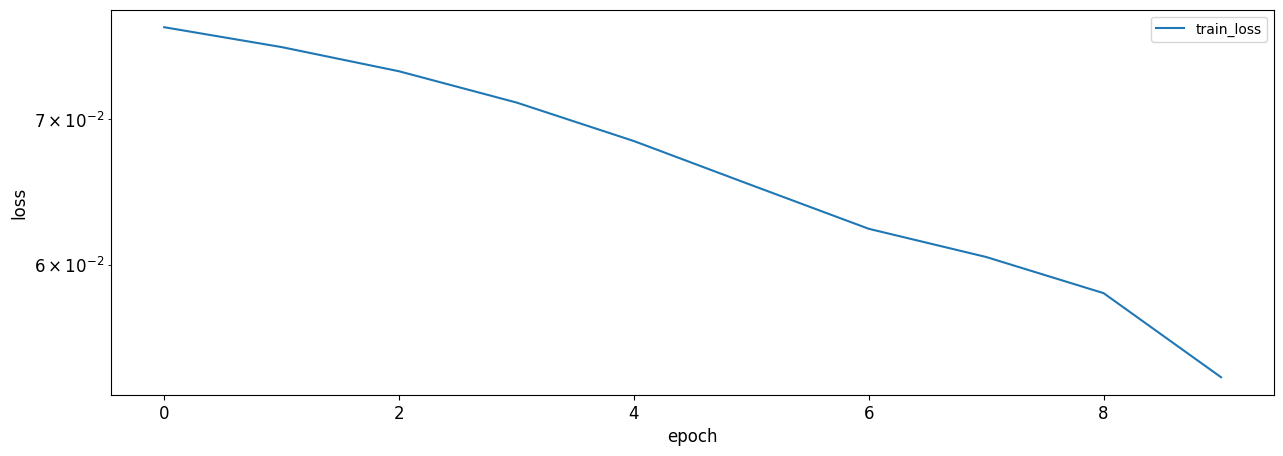

In [10]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

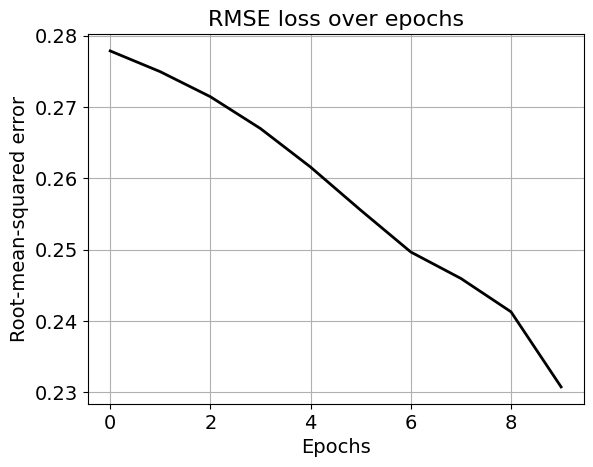

In [11]:
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(history.history['loss']), label='Training RMSE', c='k', lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Visualization of single ECG autoencoder

In [12]:
encoder_embeddings = encoder.predict(ecg100.reshape(1, -1))
encoder_embeddings

1/1 [==============================] - 0s 72ms/step


array([[-2.2016797, -2.3254373, -2.2558105, -2.0254767, -1.8566705,
        -1.860694 , -2.0020387, -2.0508306]], dtype=float32)

In [13]:
len(encoder_embeddings[0])

8

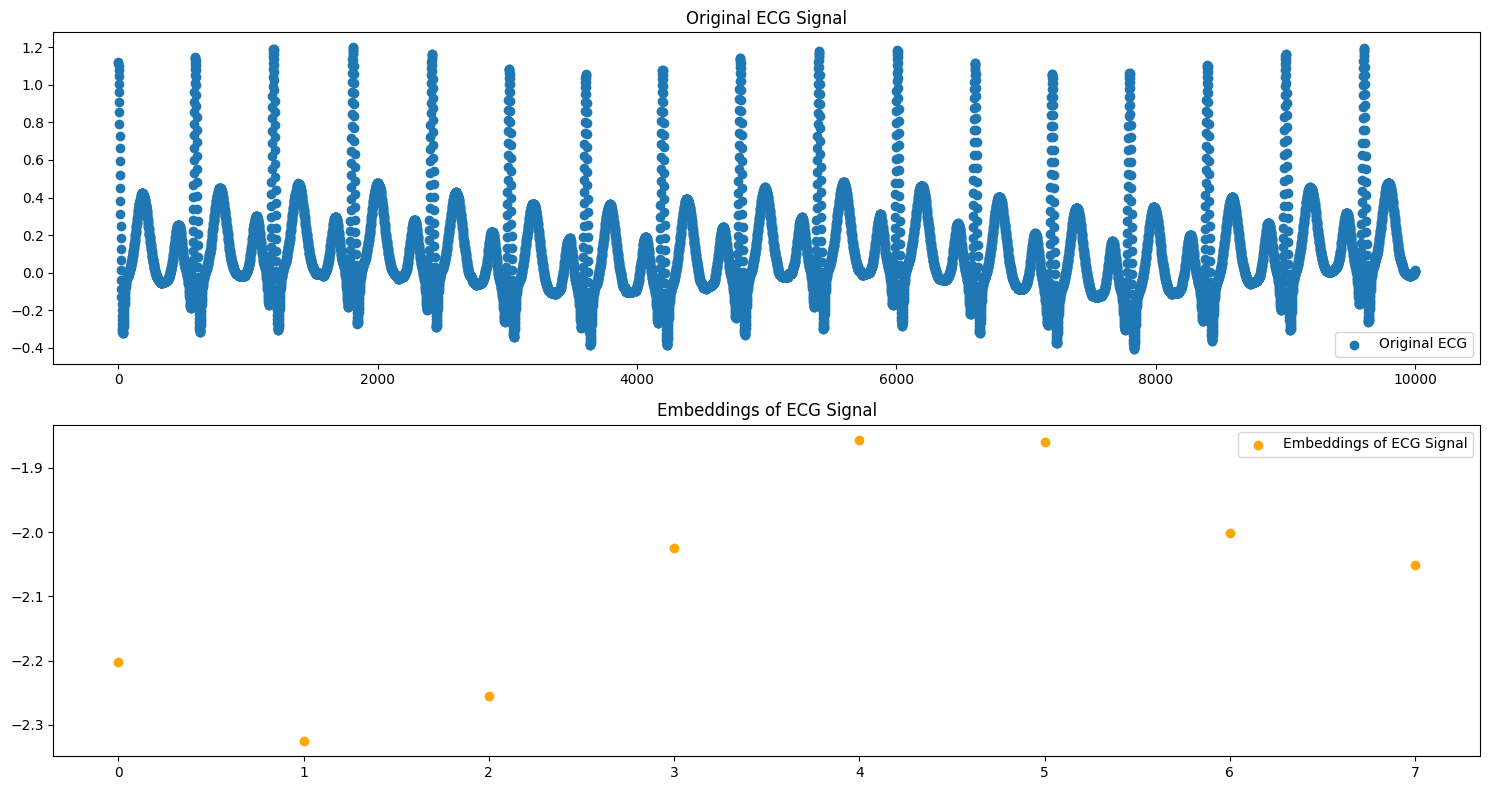

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(15, 8))

axs[0].scatter(np.arange(len(ecg100.reshape(1, -1)[0])), ecg100.reshape(1, -1)[0], label='Original ECG')
axs[0].set_title('Original ECG Signal')
axs[0].legend()

axs[1].scatter(np.arange(len(encoder_embeddings[0])), encoder_embeddings[0], label='Embeddings of ECG Signal', color='orange')
axs[1].set_title('Embeddings of ECG Signal')
axs[1].legend()

plt.tight_layout()
plt.show()

## 10 Subjects of single ECG autoencoder

In [15]:
ten_subjects = pd.read_csv('../data/ecg_10_subjects.csv')

In [16]:
ten_subjects.shape

(300000, 1)

In [17]:
ten_subjects_reshaped = ten_subjects.values.reshape((10, 30000, 1))
ten_subjects_reshaped.shape

(10, 30000, 1)

## 10 Subjects ECG autoencoder

In [18]:
encoder = tf.keras.models.Sequential([
    Conv1D(64, 10, activation='relu', padding='same', input_shape=(30000, 1)),
    Dense(32, activation='relu'),
    MaxPooling1D(),
    Conv1D(32, 10, activation='relu', padding='same'),
    Dense(16, activation='relu'),
    MaxPooling1D(),
    Flatten(),
    Dense(8)
    
], name='encoder')

In [19]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 30000, 64)         704       
                                                                 
 dense_6 (Dense)             (None, 30000, 32)         2080      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 15000, 32)         0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 15000, 32)         10272     
                                                                 
 dense_7 (Dense)             (None, 15000, 16)         528       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 7500, 16)          0         
 g1D)                                                      

In [20]:
decoder = tf.keras.models.Sequential([
    Reshape((8, 1)),
    Conv1DTranspose(8, 29993, activation='relu', input_shape=(8, 1)),
    Dense(16, activation='relu'),
    Conv1DTranspose(16, 100, activation='relu', padding='same'),
    Dense(32, activation='relu'),
    Conv1DTranspose(32, 10, activation='relu', padding='same'),
    Dense(64, activation='relu'),
    Conv1DTranspose(1, 10, activation='relu', padding='same'),
], name='decoder')

In [21]:
#decoder.summary()

In [22]:
autoencoder = Sequential([encoder, decoder])
autoencoder.summary(expand_nested=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 8)                 973592    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv1d_2 (Conv1D)          (None, 30000, 64)         704      |
|                                                               |
| dense_6 (Dense)            (None, 30000, 32)         2080     |
|                                                               |
| max_pooling1d_2 (MaxPooli  (None, 15000, 32)         0        |
| ng1D)                                                         |
|                                                               |
| conv1d_3 (Conv1D)          (None, 15000, 32)         10272    |
|                                                               |
| dense_7 (Dense)            (None, 15000, 16)         528      |
|                                                     

In [23]:
autoencoder.compile(optimizer = "adam", loss = "mse")
history = autoencoder.fit(ten_subjects_reshaped, ten_subjects_reshaped, batch_size = 128, epochs = 10, verbose = 0, callbacks=[TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

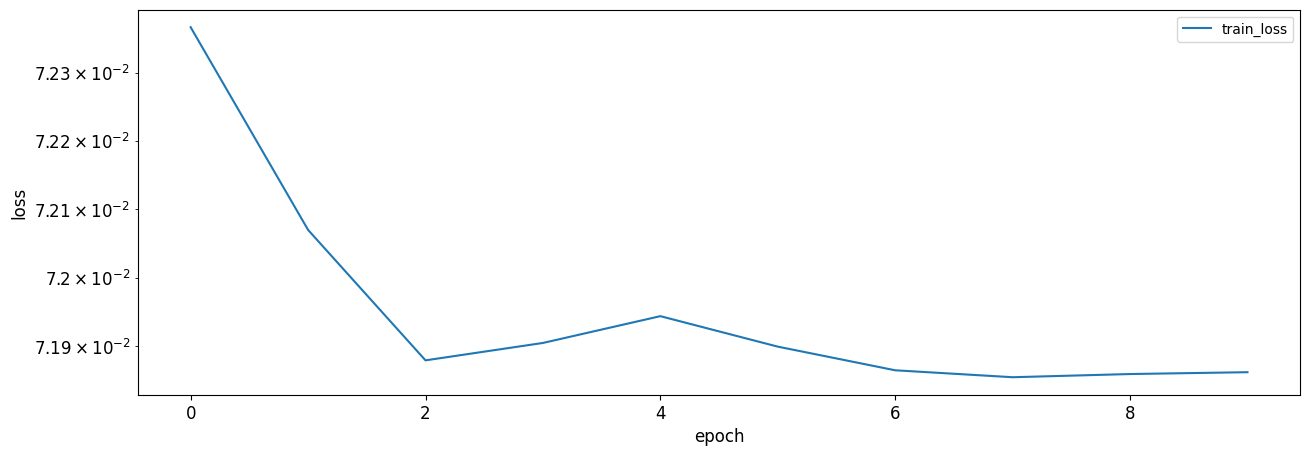

In [24]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

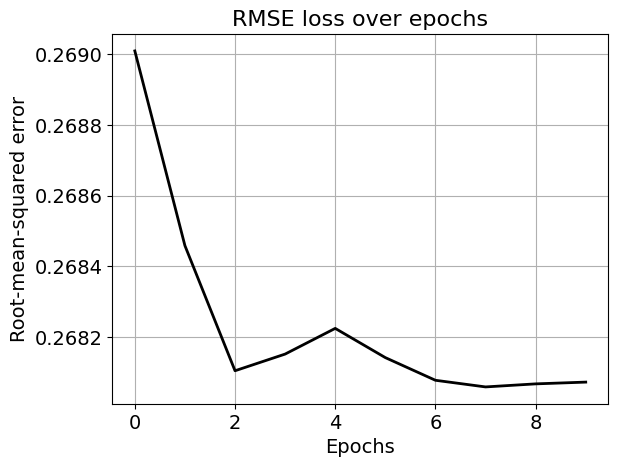

In [25]:
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(history.history['loss']), label='Training RMSE', c='k', lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [26]:
ten_encoder_embeddings = encoder.predict(ten_subjects_reshaped)
ten_encoder_embeddings

1/1 [==============================] - 0s 87ms/step


array([[-0.11393858, -0.1564206 , -0.16163975, -0.15349604, -0.12369153,
        -0.12339178, -0.14279169, -0.1542277 ],
       [-0.15801984, -0.17346917, -0.19435668, -0.18079497, -0.14175312,
        -0.14495529, -0.15436634, -0.20820767],
       [-0.32390958, -0.36936447, -0.37405667, -0.3861736 , -0.33895528,
        -0.3359979 , -0.3612861 , -0.41984728],
       [-0.2068778 , -0.23731805, -0.22816233, -0.24120604, -0.14420119,
        -0.22190282, -0.25661996, -0.29779845],
       [-0.13900091, -0.22420256, -0.23198333, -0.2529435 , -0.23155028,
        -0.18069084, -0.21174164, -0.2449652 ],
       [-0.06685188, -0.07623901, -0.08995957, -0.08934695, -0.06413328,
        -0.07339151, -0.06449143, -0.08953644],
       [-0.40824246, -0.48996088, -0.4837792 , -0.5375241 , -0.38750046,
        -0.49072325, -0.4086449 , -0.59627795],
       [-0.12077289, -0.11597174, -0.14550996, -0.13830674, -0.10292326,
        -0.13202971, -0.11748824, -0.14925107],
       [-0.13996914, -0.1761297 

## Visualization of 10 subjects ECG autoencoder

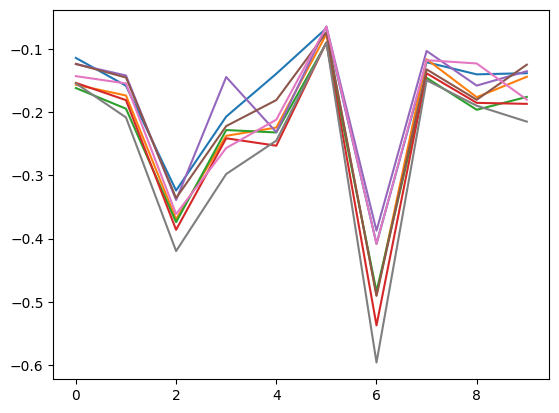

In [27]:
plt.plot(ten_encoder_embeddings)